# COE379L Project 3: Classical Model Implementation and Optimization

## Cross-Model Comparison for News Topic Classification

This notebook covers:
- TF-IDF feature extraction (unigrams and bigrams)
- XGBoost classifier with hyperparameter optimization
- Support Vector Machine (SVM) implementation (LinearSVC and RBF kernel)
- Model evaluation and performance metrics
- Training time and inference latency measurement


## 1. Import Required Libraries


In [1]:
# Standard library imports
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import time
import warnings
import sys
from datetime import datetime
from threading import Thread
warnings.filterwarnings('ignore')

# Try to import tqdm for progress bars, fallback to simple progress if not available
try:
    from tqdm import tqdm
    HAS_TQDM = True
except ImportError:
    HAS_TQDM = False
    print("Note: tqdm not available. Using simple progress tracking.")

# Scikit-learn imports
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV, cross_val_score, ParameterSampler
from sklearn.svm import LinearSVC, SVC
from sklearn.metrics import (
    accuracy_score, 
    f1_score, 
    log_loss, 
    confusion_matrix, 
    classification_report
)
from sklearn.pipeline import Pipeline

# XGBoost
import xgboost as xgb
from xgboost import XGBClassifier
from xgboost.callback import TrainingCallback

# Set style for visualizations
sns.set_style("whitegrid")
plt.rcParams['figure.figsize'] = (12, 6)

print("Libraries imported successfully!")


Libraries imported successfully!


## 2. Load Preprocessed Data


In [2]:
# Load preprocessed data from the EDA notebook
# If data files don't exist, we'll load from Hugging Face and preprocess
import os

if os.path.exists('data/train_processed.csv') and os.path.exists('data/test_processed.csv'):
    train_df = pd.read_csv('data/train_processed.csv')
    test_df = pd.read_csv('data/test_processed.csv')
    print("Loaded preprocessed data from CSV files")
else:
    # Fallback: Load and preprocess from Hugging Face
    from datasets import load_dataset
    
    print("Loading data from Hugging Face...")
    dataset = load_dataset("ag_news")
    train_df = pd.DataFrame(dataset['train'])
    test_df = pd.DataFrame(dataset['test'])
    
    # Note: AG News dataset has a single 'text' field that already contains title and description
    # The format is typically "Title. Description" - we'll use it directly as combined_text
    train_df['combined_text'] = train_df['text'].astype(str).str.strip()
    test_df['combined_text'] = test_df['text'].astype(str).str.strip()
    
    # Keep only necessary columns
    train_df = train_df[['label', 'combined_text']]
    test_df = test_df[['label', 'combined_text']]

print(f"Training samples: {len(train_df):,}")
print(f"Test samples: {len(test_df):,}")
print(f"\nClass distribution (training):")
print(train_df['label'].value_counts().sort_index())

# Prepare features and labels
X_train = train_df['combined_text'].values
y_train = train_df['label'].values
X_test = test_df['combined_text'].values
y_test = test_df['label'].values

print(f"\nX_train shape: {X_train.shape}")
print(f"y_train shape: {y_train.shape}")
print(f"X_test shape: {X_test.shape}")
print(f"y_test shape: {y_test.shape}")


Loaded preprocessed data from CSV files
Training samples: 120,000
Test samples: 7,600

Class distribution (training):
label
0    30000
1    30000
2    30000
3    30000
Name: count, dtype: int64

X_train shape: (120000,)
y_train shape: (120000,)
X_test shape: (7600,)
y_test shape: (7600,)


## 3. TF-IDF Feature Extraction

According to the project requirements, we need to generate high-dimensional sparse vector representations using unigrams and bigrams.


In [3]:
# Initialize TF-IDF vectorizer with unigrams and bigrams
# Using max_features to limit dimensionality for computational efficiency
# Adjust max_features based on available memory and computational resources
print("Initializing TF-IDF vectorizer...")
tfidf_vectorizer = TfidfVectorizer(
    ngram_range=(1, 2),  # Unigrams and bigrams
    max_features=50000,  # Limit to top 50k features for efficiency
    min_df=2,            # Ignore terms that appear in fewer than 2 documents
    max_df=0.95,         # Ignore terms that appear in more than 95% of documents
    sublinear_tf=True,   # Apply sublinear tf scaling (1 + log(tf))
    stop_words='english' # Remove English stop words
)

# Fit and transform training data
print("Fitting TF-IDF on training data...")
start_time = time.time()
X_train_tfidf = tfidf_vectorizer.fit_transform(X_train)
tfidf_fit_time = time.time() - start_time

# Transform test data
print("Transforming test data...")
X_test_tfidf = tfidf_vectorizer.transform(X_test)

print(f"\nTF-IDF Feature Extraction Complete!")
print(f"Training TF-IDF fit time: {tfidf_fit_time:.2f} seconds")
print(f"Training features shape: {X_train_tfidf.shape}")
print(f"Test features shape: {X_test_tfidf.shape}")
print(f"Number of features: {X_train_tfidf.shape[1]:,}")
print(f"Sparsity: {(1.0 - X_train_tfidf.nnz / (X_train_tfidf.shape[0] * X_train_tfidf.shape[1])) * 100:.2f}%")


Initializing TF-IDF vectorizer...
Fitting TF-IDF on training data...
Transforming test data...

TF-IDF Feature Extraction Complete!
Training TF-IDF fit time: 27.61 seconds
Training features shape: (120000, 50000)
Test features shape: (7600, 50000)
Number of features: 50,000
Sparsity: 99.95%


## 4. Helper Functions for Model Evaluation

We'll create functions to evaluate models and measure training/inference times.


In [4]:
def evaluate_model(model, X_test, y_test, model_name):
    """
    Evaluate a trained model and return metrics.
    
    Args:
        model: Trained model
        X_test: Test features
        y_test: Test labels
        model_name: Name of the model for display
    
    Returns:
        Dictionary with metrics
    """
    # Predictions
    start_time = time.time()
    y_pred = model.predict(X_test)
    inference_time = time.time() - start_time
    
    # Probabilities (for log loss)
    try:
        y_pred_proba = model.predict_proba(X_test)
    except:
        # Some models might not have predict_proba
        y_pred_proba = None
    
    # Calculate metrics
    accuracy = accuracy_score(y_test, y_pred)
    f1_macro = f1_score(y_test, y_pred, average='macro')
    
    log_loss_score = None
    if y_pred_proba is not None:
        log_loss_score = log_loss(y_test, y_pred_proba)
    
    # Inference latency per 1000 samples (handle sparse safely)
    try:
        num_samples = X_test.shape[0]
    except Exception:
        num_samples = len(X_test)
    inference_latency_per_1k = (inference_time / num_samples) * 1000
    
    results = {
        'model_name': model_name,
        'accuracy': accuracy,
        'f1_macro': f1_macro,
        'log_loss': log_loss_score,
        'inference_time': inference_time,
        'inference_latency_per_1k': inference_latency_per_1k,
        'y_pred': y_pred,
        'y_pred_proba': y_pred_proba
    }
    
    return results

def measure_inference_latency(model, X_test, num_samples=1000):
    """
    Measure inference latency for a specific number of samples.
    
    Args:
        model: Trained model
        X_test: Test features
        num_samples: Number of samples to test (default 1000)
    
    Returns:
        Time taken for inference
    """
    # Sample random indices
    indices = np.random.choice(len(X_test), min(num_samples, len(X_test)), replace=False)
    X_sample = X_test[indices]
    
    # Warm-up
    _ = model.predict(X_sample[:10])
    
    # Measure inference time
    start_time = time.time()
    _ = model.predict(X_sample)
    inference_time = time.time() - start_time
    
    return inference_time

class ProgressTracker:
    """Custom progress tracker for scikit-learn operations"""
    
    def __init__(self, total_steps, operation_name="Operation"):
        self.total_steps = total_steps
        self.current_step = 0
        self.operation_name = operation_name
        self.start_time = time.time()
        self.last_update_time = self.start_time
        
    def update(self, step=None):
        """Update progress"""
        if step is not None:
            self.current_step = step
        else:
            self.current_step += 1
            
        current_time = time.time()
        elapsed = current_time - self.start_time
        
        if self.current_step > 0:
            progress_pct = (self.current_step / self.total_steps) * 100
            avg_time_per_step = elapsed / self.current_step
            remaining_steps = self.total_steps - self.current_step
            estimated_remaining = avg_time_per_step * remaining_steps
            
            # Update every 10% or every 5 seconds
            if (current_time - self.last_update_time >= 5) or (self.current_step % max(1, self.total_steps // 10) == 0):
                print(f"{self.operation_name}: {self.current_step}/{self.total_steps} "
                      f"({progress_pct:.1f}%) | "
                      f"Elapsed: {elapsed/60:.1f}min | "
                      f"Est. remaining: {estimated_remaining/60:.1f}min")
                self.last_update_time = current_time
    
    def finish(self):
        """Mark operation as complete"""
        total_time = time.time() - self.start_time
        print(f"\n{self.operation_name} completed!")
        print(f"Total time: {total_time:.2f} seconds ({total_time/60:.2f} minutes)")
        return total_time

def track_randomized_search(random_search, X, y, operation_name="Hyperparameter Search"):
    """Wrapper for RandomizedSearchCV with progress tracking"""
    print(f"\n{'='*80}")
    print(f"Starting {operation_name}")
    print(f"{'='*80}")
    
    # Calculate total fits
    n_iter = random_search.n_iter
    cv = random_search.cv
    total_fits = n_iter * cv
    
    print(f"Configuration:")
    print(f"  Candidates: {n_iter}")
    print(f"  CV folds: {cv}")
    print(f"  Total fits: {total_fits}")
    print(f"  Samples: {X.shape[0]:,}")
    print(f"{'='*80}\n")
    
    start_time = time.time()
    
    # Fit with progress tracking
    # RandomizedSearchCV already has verbose=1 which shows progress
    print("Fitting models (progress shown below)...")
    random_search.fit(X, y)
    
    elapsed_time = time.time() - start_time
    
    print(f"\n{'─'*80}")
    print(f"{operation_name} completed!")
    print(f"Best parameters: {random_search.best_params_}")
    print(f"Best CV score: {random_search.best_score_:.4f}")
    print(f"Total time: {elapsed_time:.2f} seconds ({elapsed_time/60:.2f} minutes)")
    print(f"{'─'*80}\n")
    
    return elapsed_time

def run_param_search_with_progress(model, param_grid, X, y, n_iter=5, cv=3, scoring='f1_macro', random_state=42, operation_name="Param Search"):
    """Manual parameter search with per-iteration progress"""
    sampler = list(ParameterSampler(param_grid, n_iter=n_iter, random_state=random_state))
    total = len(sampler)
    best_score = -1
    best_params = None
    start_time = time.time()
    print(f"\n{'='*80}")
    print(f"Starting {operation_name} (manual loop)")
    print(f"Candidates: {total}, CV: {cv}, Samples: {X.shape[0]:,}")
    print(f"{'='*80}\n")
    
    iterator = tqdm(enumerate(sampler), total=total, desc=operation_name) if HAS_TQDM else enumerate(sampler)
    for i, params in iterator:
        iter_start = time.time()
        model.set_params(**params)
        scores = cross_val_score(model, X, y, cv=cv, scoring=scoring, n_jobs=-1)
        mean_score = scores.mean()
        elapsed_iter = time.time() - iter_start
        elapsed_total = time.time() - start_time
        progress_pct = ((i+1)/total)*100
        print(f"[{operation_name}] {i+1}/{total} ({progress_pct:.1f}%) | "
              f"mean {scoring}: {mean_score:.4f} | "
              f"iter time: {elapsed_iter/60:.2f}m | total: {elapsed_total/60:.2f}m | params: {params}")
        if mean_score > best_score:
            best_score = mean_score
            best_params = params
    total_time = time.time() - start_time
    print(f"\n{'─'*80}")
    print(f"{operation_name} completed!")
    print(f"Best params: {best_params}")
    print(f"Best CV score: {best_score:.4f}")
    print(f"Total time: {total_time:.2f}s ({total_time/60:.2f}m)")
    print(f"{'─'*80}\n")
    return best_params, best_score, total_time

print("Helper functions defined!")


Helper functions defined!


In [5]:
# Initialize XGBoost classifier
# Note: XGBoost works better with dense matrices, but can handle sparse
# For large sparse matrices, we'll convert to dense for better performance
print("=" * 80)
print("XGBoost Model Training")
print("=" * 80)

# For computational efficiency with large sparse matrices, we'll use a subset for hyperparameter tuning
# Then train final model on full dataset with best parameters
print("\nStep 1: Hyperparameter tuning on subset of data...")

# Use a smaller subset for faster hyperparameter search
# Note: Use shape[0] for sparse matrices, not len()
num_train_samples = X_train_tfidf.shape[0]
subset_size = min(5000, num_train_samples)  # Trim to 5k to speed up
print(f"Using {subset_size:,} samples for hyperparameter tuning (out of {num_train_samples:,} total)...")

# Use random sampling with fixed seed for reproducibility
np.random.seed(42)
indices = np.random.choice(num_train_samples, subset_size, replace=False)
X_train_subset = X_train_tfidf[indices]
y_train_subset = y_train[indices]

# Convert sparse matrix to dense for XGBoost
# XGBoost can handle sparse matrices, but dense is faster for smaller subsets
print("Converting sparse matrix to dense...")
X_train_subset_dense = X_train_subset.toarray()
print(f"Subset shape: {X_train_subset_dense.shape}")

# Define parameter grid for hyperparameter tuning
param_grid_xgb = {
    'n_estimators': [100, 200, 300],
    'max_depth': [3, 5, 7],
    'learning_rate': [0.01, 0.1, 0.2],
    'subsample': [0.8, 1.0]
}

# Initialize base model
# Note: use_label_encoder was removed in XGBoost 2.0+
# eval_metric='mlogloss' for multi-class classification
print("\nInitializing XGBoost classifier...")
xgb_base = XGBClassifier(
    random_state=42,
    n_jobs=-1,
    eval_metric='mlogloss',
    verbosity=0  # Suppress XGBoost output during search
)

# Cached best params toggle to skip re-running search
USE_CACHED_XGB_PARAMS = True
CACHED_XGB_BEST_PARAMS = {
    'subsample': 0.8,
    'n_estimators': 100,
    'max_depth': 7,
    'learning_rate': 0.2
}
CACHED_XGB_BEST_SCORE = 0.8070

# Manual param search with per-iteration progress (faster + clearer progress)
try:
    if USE_CACHED_XGB_PARAMS:
        print("Using cached XGBoost params; skipping hyperparameter search.")
        best_params = CACHED_XGB_BEST_PARAMS
        best_score = CACHED_XGB_BEST_SCORE
        hyperparameter_search_time = 0
    else:
        # Reduce search size to speed up
        xgb_n_iter = 4  # fewer candidates
        xgb_cv = 2      # 2-fold CV to cut time
        best_params, best_score, hyperparameter_search_time = run_param_search_with_progress(
            xgb_base,
            param_grid_xgb,
            X_train_subset_dense,
            y_train_subset,
            n_iter=xgb_n_iter,
            cv=xgb_cv,
            scoring='f1_macro',
            random_state=42,
            operation_name="XGBoost Hyperparameter Search"
        )
    # Build a mock object to keep interface the same
    random_search_xgb = type('obj', (object,), {
        'best_params_': best_params,
        'best_score_': best_score
    })()
except Exception as e:
    print(f"Error during hyperparameter search: {e}")
    print("Using default parameters instead...")
    # Fallback to default parameters
    random_search_xgb = type('obj', (object,), {
        'best_params_': {'n_estimators': 200, 'max_depth': 5, 'learning_rate': 0.1, 'subsample': 1.0},
        'best_score_': 0.0
    })()
    hyperparameter_search_time = 0


XGBoost Model Training

Step 1: Hyperparameter tuning on subset of data...
Using 5,000 samples for hyperparameter tuning (out of 120,000 total)...
Converting sparse matrix to dense...
Subset shape: (5000, 50000)

Initializing XGBoost classifier...
Using cached XGBoost params; skipping hyperparameter search.


In [6]:
# Step 2: Train final XGBoost model on full dataset with best parameters
print("\n" + "=" * 80)
print("Step 2: Training final XGBoost model on full dataset...")

# For full dataset, we'll use a sample if the dataset is too large
# XGBoost can handle large datasets, but for memory efficiency, we might sample
num_train_samples = X_train_tfidf.shape[0]
full_train_size = min(50000, num_train_samples)  # Use up to 50k samples for final training
if full_train_size < num_train_samples:
    print(f"Using {full_train_size:,} samples for final training (for computational efficiency)")
    np.random.seed(42)  # Set seed for reproducibility
    indices_full = np.random.choice(num_train_samples, full_train_size, replace=False)
    X_train_final = X_train_tfidf[indices_full]
    y_train_final = y_train[indices_full]
else:
    X_train_final = X_train_tfidf
    y_train_final = y_train

# Convert to dense matrix
print("Converting to dense matrix for XGBoost...")
X_train_final_dense = X_train_final.toarray()
print(f"Final training set shape: {X_train_final_dense.shape}")

# Create final model with best parameters
print(f"\nInitializing XGBoost with best parameters: {random_search_xgb.best_params_}")
xgb_final = XGBClassifier(
    **random_search_xgb.best_params_,
    random_state=42,
    n_jobs=-1,
    eval_metric='mlogloss',
    verbosity=0
)

# Train final model with progress tracking
print("\n" + "=" * 80)
print("Training Final XGBoost Model")
print("=" * 80)
print(f"Training samples: {X_train_final_dense.shape[0]:,}")
print(f"Features: {X_train_final_dense.shape[1]:,}")
print(f"Parameters: {random_search_xgb.best_params_}")
print("=" * 80 + "\n")

# Custom progress callback for XGBoost
class XGBProgressCallback(TrainingCallback):
    def __init__(self, total_rounds, log_interval=10):
        self.total_rounds = total_rounds
        self.log_interval = log_interval
        self.start_time = None
    def before_training(self, model):
        self.start_time = time.time()
        print("XGBoost training progress:")
        return model
    def after_iteration(self, model, epoch, evals_log):
        if self.start_time is None:
            self.start_time = time.time()
        if (epoch + 1) % self.log_interval == 0 or epoch == 0:
            elapsed = time.time() - self.start_time
            pct = ((epoch + 1) / self.total_rounds) * 100
            last_loss = None
            try:
                # Take first eval set's mlogloss if available
                first_eval = next(iter(evals_log.values()))
                if 'mlogloss' in first_eval:
                    last_loss = first_eval['mlogloss'][-1]
            except Exception:
                pass
            msg = f"[XGBoost] Iter {epoch+1}/{self.total_rounds} ({pct:5.1f}%) | Elapsed {elapsed/60:.2f}m"
            if last_loss is not None:
                msg += f" | mlogloss {last_loss:.4f}"
            print(msg)
        return False

start_time = time.time()
print("Training in progress... (custom progress every 10 trees)")

try:
    # Use a small eval subset to keep logging fast
    eval_sample = min(2000, X_train_final_dense.shape[0])
    eval_set = [(X_train_final_dense[:eval_sample], y_train_final[:eval_sample])]
    total_rounds = xgb_final.get_params().get('n_estimators', 100)
    print(f"Progress key: line [k] means {(1/total_rounds):.1%} * (k+1) of training (total rounds: {total_rounds})")
    
    xgb_final.fit(
        X_train_final_dense,
        y_train_final,
        eval_set=eval_set,
        verbose=10  # progress every 10 trees via built-in logging
    )
    xgb_training_time = time.time() - start_time
    
    print(f"\n{'─'*80}")
    print(f"Training completed!")
    print(f"Time: {xgb_training_time:.2f} seconds ({xgb_training_time/60:.2f} minutes)")
    print(f"{'─'*80}\n")
    
    # Evaluate model
    print("\nEvaluating XGBoost model...")
    print("Converting test set to dense matrix...")
    X_test_dense = X_test_tfidf.toarray()
    
    xgb_results = evaluate_model(xgb_final, X_test_dense, y_test, "XGBoost")
    
    print(f"\nXGBoost Results:")
    print(f"  Accuracy: {xgb_results['accuracy']:.4f}")
    print(f"  Macro F1-Score: {xgb_results['f1_macro']:.4f}")
    print(f"  Log Loss: {xgb_results['log_loss']:.4f}")
    print(f"  Training Time: {xgb_training_time:.2f} seconds")
    print(f"  Inference Latency (per 1,000 samples): {xgb_results['inference_latency_per_1k']:.4f} seconds")
    
except Exception as e:
    print(f"Error during training or evaluation: {e}")
    import traceback
    traceback.print_exc()
    raise



Step 2: Training final XGBoost model on full dataset...
Using 50,000 samples for final training (for computational efficiency)
Converting to dense matrix for XGBoost...
Final training set shape: (50000, 50000)

Initializing XGBoost with best parameters: {'subsample': 0.8, 'n_estimators': 100, 'max_depth': 7, 'learning_rate': 0.2}

Training Final XGBoost Model
Training samples: 50,000
Features: 50,000
Parameters: {'subsample': 0.8, 'n_estimators': 100, 'max_depth': 7, 'learning_rate': 0.2}

Training in progress... (custom progress every 10 trees)
Progress key: line [k] means 1.0% * (k+1) of training (total rounds: 100)
[0]	validation_0-mlogloss:1.27295
[10]	validation_0-mlogloss:0.86760
[20]	validation_0-mlogloss:0.71789
[30]	validation_0-mlogloss:0.62863
[40]	validation_0-mlogloss:0.56448
[50]	validation_0-mlogloss:0.51670
[60]	validation_0-mlogloss:0.47746
[70]	validation_0-mlogloss:0.44640
[80]	validation_0-mlogloss:0.42013
[90]	validation_0-mlogloss:0.39723
[99]	validation_0-mloglo

## 6. Support Vector Machine (SVM) - LinearSVC

We'll implement LinearSVC which is more efficient than SVC for large datasets.


In [7]:
# LinearSVC is more efficient for large sparse matrices
print("=" * 80)
print("SVM LinearSVC Model Training")
print("=" * 80)

# Define parameter grid for LinearSVC
param_grid_svm_linear = {
    'C': [0.1, 1.0, 10.0, 100.0],
    'penalty': ['l2'],
    'loss': ['squared_hinge'],
    'max_iter': [1000, 2000]
}

# Initialize base model
svm_linear_base = LinearSVC(random_state=42, dual=False)  # dual=False for n_samples > n_features

# Use RandomizedSearchCV
print("Running RandomizedSearchCV for LinearSVC...")
start_time = time.time()
random_search_svm_linear = RandomizedSearchCV(
    estimator=svm_linear_base,
    param_distributions=param_grid_svm_linear,
    n_iter=8,
    cv=3,
    scoring='f1_macro',
    n_jobs=-1,
    random_state=42,
    verbose=1
)

# Use subset for hyperparameter tuning
random_search_svm_linear.fit(X_train_subset, y_train_subset)
svm_linear_hyperparameter_time = time.time() - start_time

print(f"\nHyperparameter search completed in {svm_linear_hyperparameter_time:.2f} seconds")
print(f"Best parameters: {random_search_svm_linear.best_params_}")
print(f"Best CV score: {random_search_svm_linear.best_score_:.4f}")


SVM LinearSVC Model Training
Running RandomizedSearchCV for LinearSVC...
Fitting 3 folds for each of 8 candidates, totalling 24 fits

Hyperparameter search completed in 8.54 seconds
Best parameters: {'penalty': 'l2', 'max_iter': 1000, 'loss': 'squared_hinge', 'C': 1.0}
Best CV score: 0.8902


In [8]:
# Train final LinearSVC model on full dataset
print("\nTraining final LinearSVC model on full dataset...")

svm_linear_final = LinearSVC(
    **random_search_svm_linear.best_params_,
    random_state=42,
    dual=False
)

print("\n" + "=" * 80)
print("Training Final SVM LinearSVC Model")
print("=" * 80)
print(f"Training samples: {X_train_tfidf.shape[0]:,}")
print(f"Features: {X_train_tfidf.shape[1]:,}")
print(f"Parameters: {random_search_svm_linear.best_params_}")
print("=" * 80 + "\n")

print("Training in progress... (ping every 10s)")
start_time = time.time()
stop_flag = {'stop': False}

def svm_progress_pinger():
    while not stop_flag['stop']:
        time.sleep(10)
        elapsed = time.time() - start_time
        print(f"[LinearSVC training] Elapsed {elapsed/60:.1f} min ...")

pinger = Thread(target=svm_progress_pinger, daemon=True)
pinger.start()

svm_linear_final.fit(X_train_tfidf, y_train)
stop_flag['stop'] = True
pinger.join(timeout=1)
svm_linear_training_time = time.time() - start_time

print(f"\n{'─'*80}")
print(f"Training completed!")
print(f"Time: {svm_linear_training_time:.2f} seconds ({svm_linear_training_time/60:.2f} minutes)")
print(f"{'─'*80}\n")

# Evaluate model
print("\nEvaluating LinearSVC model...")
svm_linear_results = evaluate_model(svm_linear_final, X_test_tfidf, y_test, "SVM-LinearSVC")

# LinearSVC doesn't have predict_proba by default, so log_loss will be None
# This is expected behavior for LinearSVC
print(f"\nSVM LinearSVC Results:")
print(f"  Accuracy: {svm_linear_results['accuracy']:.4f}")
print(f"  Macro F1-Score: {svm_linear_results['f1_macro']:.4f}")
print(f"  Log Loss: {svm_linear_results['log_loss']} (LinearSVC doesn't support probability estimates)")
print(f"  Training Time: {svm_linear_training_time:.2f} seconds")
print(f"  Inference Latency (per 1,000 samples): {svm_linear_results['inference_latency_per_1k']:.4f} seconds")



Training final LinearSVC model on full dataset...

Training Final SVM LinearSVC Model
Training samples: 120,000
Features: 50,000
Parameters: {'penalty': 'l2', 'max_iter': 1000, 'loss': 'squared_hinge', 'C': 1.0}

Training in progress... (ping every 10s)

────────────────────────────────────────────────────────────────────────────────
Training completed!
Time: 9.82 seconds (0.16 minutes)
────────────────────────────────────────────────────────────────────────────────


Evaluating LinearSVC model...

SVM LinearSVC Results:
  Accuracy: 0.9228
  Macro F1-Score: 0.9226
  Log Loss: None (LinearSVC doesn't support probability estimates)
  Training Time: 9.82 seconds
  Inference Latency (per 1,000 samples): 0.0044 seconds


## 7. Support Vector Machine (SVM) - RBF Kernel

We'll also implement SVC with RBF kernel for comparison, though it's computationally more expensive.


In [ ]:
# SVC with RBF kernel - more computationally expensive
# We'll use a smaller subset due to computational constraints
print("=" * 80)
print("SVM RBF Kernel Model Training")
print("=" * 80)
print("Note: RBF kernel is computationally expensive. Using smaller subset for training.")

# Use smaller subset for RBF kernel
num_train_samples = X_train_tfidf.shape[0]
rbf_subset_size = min(2000, num_train_samples)  # reduced for speed
print(f"Using {rbf_subset_size:,} samples for RBF SVM training...")
np.random.seed(42)  # Set seed for reproducibility
indices_rbf = np.random.choice(num_train_samples, rbf_subset_size, replace=False)
X_train_rbf = X_train_tfidf[indices_rbf].toarray()  # RBF needs dense matrix
y_train_rbf = y_train[indices_rbf]

# Define a tighter/smaller parameter grid for RBF SVC
def clean_params(params_list):
    seen = set()
    cleaned = []
    for p in params_list:
        key = tuple(sorted(p.items()))
        if key not in seen:
            seen.add(key)
            cleaned.append(p)
    return cleaned

param_grid_svm_rbf = {
    'C': [1.0, 10.0],
    'gamma': ['scale', 0.001]
}

# Initialize base model
svm_rbf_base = SVC(kernel='rbf', random_state=42, probability=True)  # probability=True for predict_proba

# Cached best params toggle to skip re-running search
USE_CACHED_SVM_RBF_PARAMS = True
CACHED_SVM_RBF_BEST_PARAMS = {
    'gamma': 'scale',
    'C': 1.0
}
CACHED_SVM_RBF_BEST_SCORE = 0.8269

# Use RandomizedSearchCV with fewer iterations and folds for speed
if USE_CACHED_SVM_RBF_PARAMS:
    print("Using cached SVM RBF params; skipping hyperparameter search.")
    best_params_rbf = CACHED_SVM_RBF_BEST_PARAMS
    best_score_rbf = CACHED_SVM_RBF_BEST_SCORE
    svm_rbf_hyperparameter_time = 0
    # Build a mock object to keep interface the same
    random_search_svm_rbf = type('obj', (object,), {
        'best_params_': best_params_rbf,
        'best_score_': best_score_rbf
    })()
else:
    print("Running RandomizedSearchCV for RBF SVC (smaller search)...")
    random_search_svm_rbf = RandomizedSearchCV(
        estimator=svm_rbf_base,
        param_distributions=param_grid_svm_rbf,
        n_iter=3,  # fewer iterations
        cv=2,      # 2-fold CV to reduce time
        scoring='f1_macro',
        n_jobs=-1,
        random_state=42,
        verbose=1
    )
    
    svm_rbf_hyperparameter_time = track_randomized_search(
        random_search_svm_rbf,
        X_train_rbf,
        y_train_rbf,
        operation_name="SVM RBF Hyperparameter Search (fast)"
    )


SVM RBF Kernel Model Training
Note: RBF kernel is computationally expensive. Using smaller subset for training.
Using 2,000 samples for RBF SVM training...
Running RandomizedSearchCV for RBF SVC (smaller search)...

Starting SVM RBF Hyperparameter Search (fast)
Configuration:
  Candidates: 3
  CV folds: 2
  Total fits: 6
  Samples: 2,000

Fitting models (progress shown below)...
Fitting 2 folds for each of 3 candidates, totalling 6 fits

────────────────────────────────────────────────────────────────────────────────
SVM RBF Hyperparameter Search (fast) completed!
Best parameters: {'gamma': 'scale', 'C': 1.0}
Best CV score: 0.8269
Total time: 2746.64 seconds (45.78 minutes)
────────────────────────────────────────────────────────────────────────────────



In [11]:
# Train final RBF SVC model
print("\nTraining final RBF SVC model...")

svm_rbf_final = SVC(
    **random_search_svm_rbf.best_params_,
    kernel='rbf',
    random_state=42,
    probability=True
)

print("\n" + "=" * 80)
print("Training Final SVM RBF Model")
print("=" * 80)
print(f"Training samples: {X_train_rbf.shape[0]:,}")
print(f"Features: {X_train_rbf.shape[1]:,}")
print(f"Parameters: {random_search_svm_rbf.best_params_}")
print("=" * 80 + "\n")

print("Training in progress... (ping every 10s)")
start_time = time.time()
stop_flag = {'stop': False}

def svm_rbf_progress_pinger():
    while not stop_flag['stop']:
        time.sleep(10)
        elapsed = time.time() - start_time
        print(f"[SVM RBF training] Elapsed {elapsed/60:.1f} min ...")

pinger = Thread(target=svm_rbf_progress_pinger, daemon=True)
pinger.start()

svm_rbf_final.fit(X_train_rbf, y_train_rbf)
stop_flag['stop'] = True
pinger.join(timeout=1)
svm_rbf_training_time = time.time() - start_time

print(f"\n{'─'*80}")
print(f"Training completed!")
print(f"Time: {svm_rbf_training_time:.2f} seconds ({svm_rbf_training_time/60:.2f} minutes)")
print(f"{'─'*80}\n")

# Evaluate model
print("\nEvaluating RBF SVC model...")
print("Converting test set to dense matrix (this may take a moment)...")
eval_start = time.time()
X_test_dense = X_test_tfidf.toarray()
print(f"Matrix conversion completed in {time.time() - eval_start:.1f} seconds")
print("Running predictions on test set...")
svm_rbf_results = evaluate_model(svm_rbf_final, X_test_dense, y_test, "SVM-RBF")
eval_time = time.time() - eval_start
print(f"Evaluation completed in {eval_time:.1f} seconds ({eval_time/60:.2f} minutes)")

print(f"\nSVM RBF Results:")
print(f"  Accuracy: {svm_rbf_results['accuracy']:.4f}")
print(f"  Macro F1-Score: {svm_rbf_results['f1_macro']:.4f}")
print(f"  Log Loss: {svm_rbf_results['log_loss']:.4f}")
print(f"  Training Time: {svm_rbf_training_time:.2f} seconds")
print(f"  Inference Latency (per 1,000 samples): {svm_rbf_results['inference_latency_per_1k']:.4f} seconds")



Training final RBF SVC model...

Training Final SVM RBF Model
Training samples: 2,000
Features: 50,000
Parameters: {'gamma': 'scale', 'C': 1.0}

Training in progress... (ping every 10s)
[SVM RBF training] Elapsed 0.2 min ...
[SVM RBF training] Elapsed 0.3 min ...
[SVM RBF training] Elapsed 0.5 min ...
[SVM RBF training] Elapsed 0.7 min ...
[SVM RBF training] Elapsed 0.8 min ...
[SVM RBF training] Elapsed 1.0 min ...
[SVM RBF training] Elapsed 1.2 min ...
[SVM RBF training] Elapsed 1.3 min ...
[SVM RBF training] Elapsed 1.5 min ...
[SVM RBF training] Elapsed 1.7 min ...
[SVM RBF training] Elapsed 1.8 min ...
[SVM RBF training] Elapsed 2.0 min ...
[SVM RBF training] Elapsed 2.2 min ...
[SVM RBF training] Elapsed 2.3 min ...
[SVM RBF training] Elapsed 2.5 min ...
[SVM RBF training] Elapsed 2.7 min ...
[SVM RBF training] Elapsed 2.8 min ...
[SVM RBF training] Elapsed 3.0 min ...
[SVM RBF training] Elapsed 3.2 min ...
[SVM RBF training] Elapsed 3.3 min ...
[SVM RBF training] Elapsed 3.5 mi

## 8. Results Summary and Comparison


In [12]:
# Compile all results
results_summary = []

# Add XGBoost results
results_summary.append({
    'Model': 'XGBoost',
    'Accuracy': xgb_results['accuracy'],
    'Macro F1-Score': xgb_results['f1_macro'],
    'Log Loss': xgb_results['log_loss'],
    'Training Time (s)': xgb_training_time,
    'Inference Latency per 1k (s)': xgb_results['inference_latency_per_1k']
})

# Add LinearSVC results
results_summary.append({
    'Model': 'SVM-LinearSVC',
    'Accuracy': svm_linear_results['accuracy'],
    'Macro F1-Score': svm_linear_results['f1_macro'],
    'Log Loss': svm_linear_results['log_loss'] if svm_linear_results['log_loss'] is not None else np.nan,
    'Training Time (s)': svm_linear_training_time,
    'Inference Latency per 1k (s)': svm_linear_results['inference_latency_per_1k']
})

# Add RBF SVC results
results_summary.append({
    'Model': 'SVM-RBF',
    'Accuracy': svm_rbf_results['accuracy'],
    'Macro F1-Score': svm_rbf_results['f1_macro'],
    'Log Loss': svm_rbf_results['log_loss'],
    'Training Time (s)': svm_rbf_training_time,
    'Inference Latency per 1k (s)': svm_rbf_results['inference_latency_per_1k']
})

# Create DataFrame
results_df = pd.DataFrame(results_summary)

print("=" * 80)
print("CLASSICAL MODELS - RESULTS SUMMARY")
print("=" * 80)
print(results_df.to_string(index=False))
print("=" * 80)

# Ensure data directory exists
os.makedirs('data', exist_ok=True)

# Save results
results_df.to_csv('data/classical_models_results.csv', index=False)
print("\nResults saved to data/classical_models_results.csv")


CLASSICAL MODELS - RESULTS SUMMARY
        Model  Accuracy  Macro F1-Score  Log Loss  Training Time (s)  Inference Latency per 1k (s)
      XGBoost  0.880921        0.880733  0.439884        2862.118365                      0.162811
SVM-LinearSVC  0.922763        0.922597       NaN           9.819338                      0.004442
      SVM-RBF  0.864474        0.863662  0.441058        1653.901496                    181.571079

Results saved to data/classical_models_results.csv


## 9. Visualizations


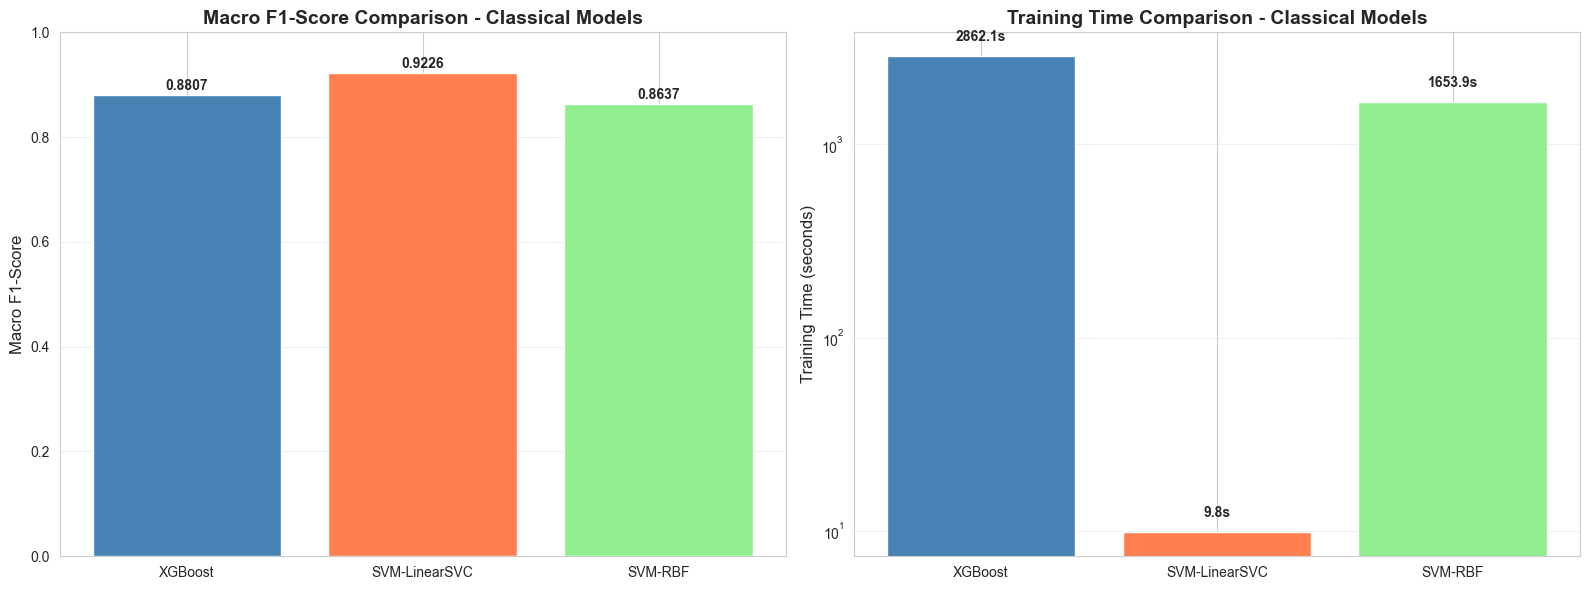

Visualization saved to data/classical_models_comparison.png


In [13]:
# Bar chart comparing F1-scores
fig, axes = plt.subplots(1, 2, figsize=(16, 6))

# F1-Score comparison
models = results_df['Model'].values
f1_scores = results_df['Macro F1-Score'].values

axes[0].bar(models, f1_scores, color=['steelblue', 'coral', 'lightgreen'])
axes[0].set_title('Macro F1-Score Comparison - Classical Models', fontsize=14, fontweight='bold')
axes[0].set_ylabel('Macro F1-Score', fontsize=12)
axes[0].set_ylim([0, 1])
axes[0].grid(axis='y', alpha=0.3)
for i, v in enumerate(f1_scores):
    axes[0].text(i, v + 0.01, f'{v:.4f}', ha='center', fontweight='bold')

# Training time comparison
training_times = results_df['Training Time (s)'].values
axes[1].bar(models, training_times, color=['steelblue', 'coral', 'lightgreen'])
axes[1].set_title('Training Time Comparison - Classical Models', fontsize=14, fontweight='bold')
axes[1].set_ylabel('Training Time (seconds)', fontsize=12)
axes[1].set_yscale('log')  # Log scale for better visualization
axes[1].grid(axis='y', alpha=0.3)
for i, v in enumerate(training_times):
    axes[1].text(i, v * 1.2, f'{v:.1f}s', ha='center', fontweight='bold')

plt.tight_layout()
os.makedirs('data', exist_ok=True)
plt.savefig('data/classical_models_comparison.png', dpi=300, bbox_inches='tight')
plt.show()
print("Visualization saved to data/classical_models_comparison.png")


## 10. Confusion Matrices

We'll create confusion matrices for the best-performing classical model.


Best performing classical model: SVM-LinearSVC
F1-Score: 0.9226


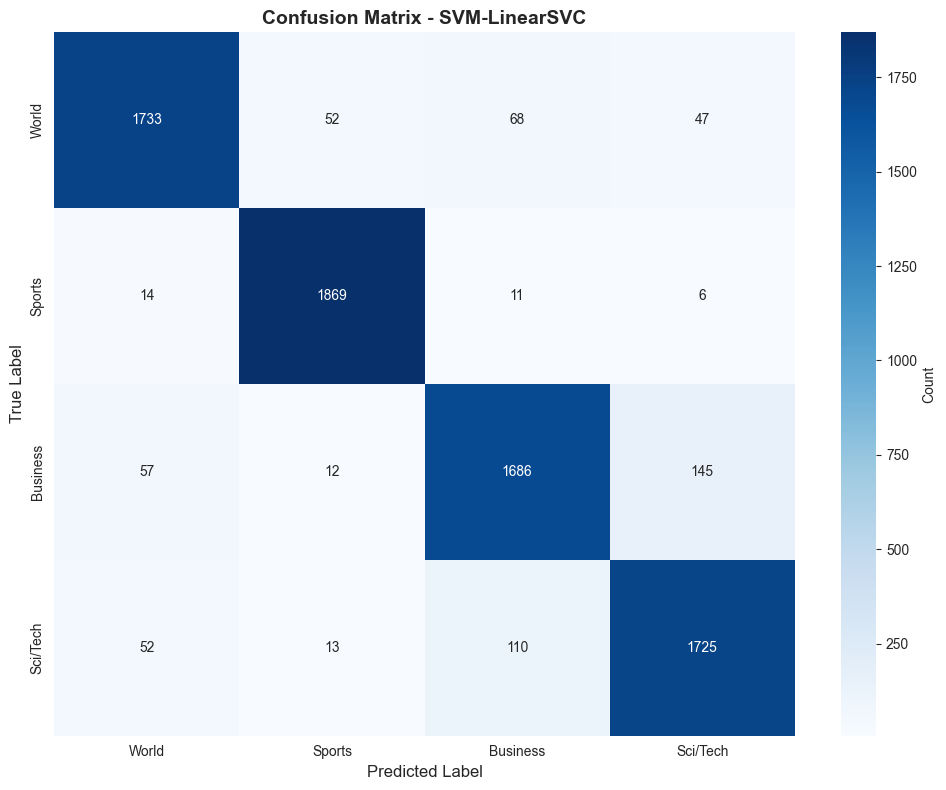

Confusion matrix saved to data/classical_models_confusion_matrix.png

Classification Report:
              precision    recall  f1-score   support

       World       0.93      0.91      0.92      1900
      Sports       0.96      0.98      0.97      1900
    Business       0.90      0.89      0.89      1900
    Sci/Tech       0.90      0.91      0.90      1900

    accuracy                           0.92      7600
   macro avg       0.92      0.92      0.92      7600
weighted avg       0.92      0.92      0.92      7600



In [14]:
# Find best model based on F1-score
best_model_idx = results_df['Macro F1-Score'].idxmax()
best_model_name = results_df.loc[best_model_idx, 'Model']

print(f"Best performing classical model: {best_model_name}")
print(f"F1-Score: {results_df.loc[best_model_idx, 'Macro F1-Score']:.4f}")

# Get predictions for best model
if best_model_name == 'XGBoost':
    best_predictions = xgb_results['y_pred']
    best_model_obj = xgb_final
elif best_model_name == 'SVM-LinearSVC':
    best_predictions = svm_linear_results['y_pred']
    best_model_obj = svm_linear_final
else:  # SVM-RBF
    best_predictions = svm_rbf_results['y_pred']
    best_model_obj = svm_rbf_final

# Class labels
class_labels = ['World', 'Sports', 'Business', 'Sci/Tech']

# Create confusion matrix
cm = confusion_matrix(y_test, best_predictions)

# Plot confusion matrix
plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', 
            xticklabels=class_labels, yticklabels=class_labels,
            cbar_kws={'label': 'Count'})
plt.title(f'Confusion Matrix - {best_model_name}', fontsize=14, fontweight='bold')
plt.ylabel('True Label', fontsize=12)
plt.xlabel('Predicted Label', fontsize=12)
plt.tight_layout()
os.makedirs('data', exist_ok=True)
plt.savefig('data/classical_models_confusion_matrix.png', dpi=300, bbox_inches='tight')
plt.show()
print("Confusion matrix saved to data/classical_models_confusion_matrix.png")

# Print classification report
print("\nClassification Report:")
print(classification_report(y_test, best_predictions, target_names=class_labels))


## 11. Save Models and Results

We'll save the trained models and all results for later use.


In [15]:
# Save models using joblib
import joblib

# Ensure data directory exists
os.makedirs('data', exist_ok=True)

print("Saving models and vectorizer...")

# Save TF-IDF vectorizer
joblib.dump(tfidf_vectorizer, 'data/tfidf_vectorizer.pkl')
print("✓ TF-IDF vectorizer saved")

# Save XGBoost model
joblib.dump(xgb_final, 'data/xgb_model.pkl')
print("✓ XGBoost model saved")

# Save LinearSVC model
joblib.dump(svm_linear_final, 'data/svm_linear_model.pkl')
print("✓ SVM LinearSVC model saved")

# Save RBF SVC model
joblib.dump(svm_rbf_final, 'data/svm_rbf_model.pkl')
print("✓ SVM RBF model saved")

print("\nAll models and results saved successfully!")
print("Ready for comparison with transformer models in the next notebook.")


Saving models and vectorizer...
✓ TF-IDF vectorizer saved
✓ XGBoost model saved
✓ SVM LinearSVC model saved
✓ SVM RBF model saved

All models and results saved successfully!
Ready for comparison with transformer models in the next notebook.
